In [18]:
import networkx as nx
import re
from collections import deque # for popping from the left of a list
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
SEQUENCE = "[XIC(A) [XIC(B) ,XIC(C) ] ,XIO(A) XIC(D) ]TON(E);"

spaces_removed_seq = re.sub(' ','',SEQUENCE)

In [46]:
G = nx.Graph()
G.add_node('start')

paths_to_traverse = deque([('start',spaces_removed_seq)])

In [47]:
nodes_needing_termination = set()

while paths_to_traverse:
    current_node_name, work_seq = paths_to_traverse.popleft()
    print(f"picking up from {current_node_name} to map sequence: {work_seq}")
    
    brackets_needing_closure = 0
    start_of_closure_to_buffer = 0
    branching_from_node = None

    for idx,char in enumerate(work_seq):
        if char == 'X' and brackets_needing_closure <= 1:
            next_node_name = work_seq[idx:idx+6]
            G.add_node(next_node_name)
            G.add_edge(current_node_name, next_node_name)
            try:
                nodes_needing_termination.remove(current_node_name)
            except:
                pass
            print(f"adding edge from {current_node_name} to {next_node_name}")
            current_node_name = next_node_name
            nodes_needing_termination.add(current_node_name)
            print(f"working from {current_node_name}")
        elif char == '[':
            brackets_needing_closure += 1
            if brackets_needing_closure == 1:
                branching_from_node = current_node_name
            elif brackets_needing_closure == 2:
                start_of_closure_to_buffer = idx
            
        elif char == ']':
            brackets_needing_closure -= 1
            if brackets_needing_closure == 1:
                paths_to_traverse.append((current_node_name,work_seq[start_of_closure_to_buffer:idx+1]))
        elif char ==',' and brackets_needing_closure <= 1:
            current_node_name = branching_from_node
            print(f"picking back up from {current_node_name}")
        elif char =='T':
            terminating_node_name = work_seq[idx:idx+6]
            G.add_node(terminating_node_name)
            
for unterminated_node in nodes_needing_termination:
    G.add_edge(unterminated_node, terminating_node_name)

picking up from start to map sequence: [XIC(A)[XIC(B),XIC(C)],XIO(A)XIC(D)]TON(E);
adding edge from start to XIC(A)
working from XIC(A)
picking back up from start
adding edge from start to XIO(A)
working from XIO(A)
adding edge from XIO(A) to XIC(D)
working from XIC(D)
picking up from XIC(A) to map sequence: [XIC(B),XIC(C)]
adding edge from XIC(A) to XIC(B)
working from XIC(B)
picking back up from XIC(A)
adding edge from XIC(A) to XIC(C)
working from XIC(C)


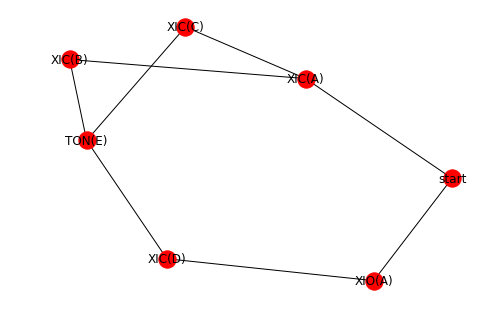

In [48]:
nx.draw(G, with_labels=True)
plt.show()